本Notebook中我们会讨论三个主题：
1. 如何创建RNN神经网络
2. 神经网络的形状和张量的维度
3. 如何批量训练RNN

## RNN 与 前馈神经网络架构

前馈神经网络与RNN相比，模型架构更简单
- 前馈神经网络中只有一个输入张量，一个可训练权重矩阵，一个输出张量
- 循环神经网络有2个输入张量，3个可训练权重矩阵和两个输出张量

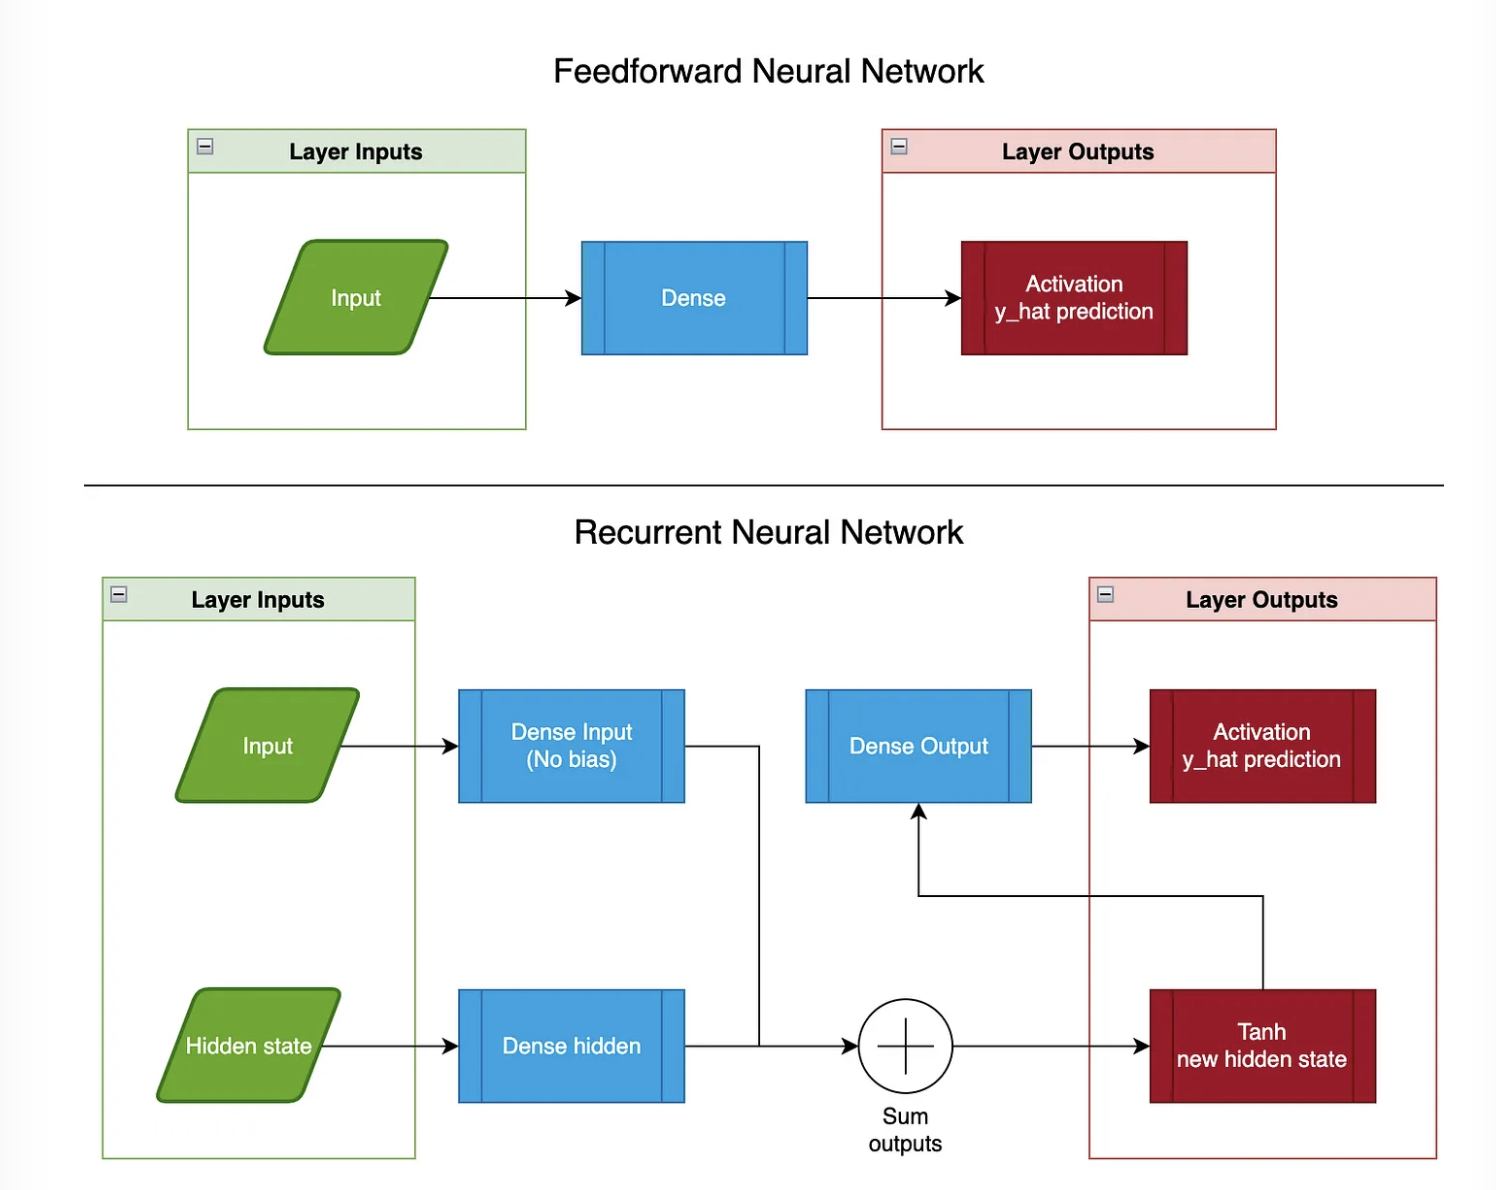


RNN 引入了一个新的概念`隐藏状态`
- 隐藏状态基于之前的模型输出
- 初始状态为0

与FNN不同的是，RNN与序列数据打交道，因此输入数据的顺序是很重要的，因此每次我们向神经网络中送数据，我们只能输入一个数据

每一次的训练迭代都会计算当前时刻的隐藏状态，这个隐藏状态不仅会携带过去的信息，也会记录当前的信息，这一过程是通过矩阵的求和得到的



### 输入

输入张量

- 序列中的一个文本/信息/元素；如果序列是一个长度为100个字符的文本，那么每次的输入就会是一个字符

隐藏状态张量

- 上一个时刻模型的输出结果，也就是隐藏状态；在序列的开头位置（不存在上一时刻时），这个张量是通过0进行填充的

### 权重矩阵

输入密集矩阵

- 用于计算当前输入的密集矩阵

隐藏密集矩阵

- 用于计算隐藏状态的密集矩阵

输出密集矩阵

- 用于计算激活输入和隐藏的矩阵之和的矩阵(softmax 前的步骤)
- `activation(input_dense + hidden_dense)`

### 输出

新的隐藏状态/当前时刻的输出状态

- `activation(input_dense + hidden_dense)` 用作下一时刻迭代的输入

输出

- `activation(output_dense)` 模型在当前时刻的输出



In [ ]:
# 引入依赖

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device")

Using 'cuda' device


In [ ]:
# RNN 网络构建

class RNN(nn.module):
  '''
  input_size: 输入向量的特征数量
  hidden_size: 隐藏层的参数维度
  output_size: 输出向量的特征数量
  '''
  def __init__(self, input_size: int, hidden_size: int, output_size:int) -> None:
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.batch_size = batch_size
    self.i2h = nn.linear(input_size, hidden_size, bias=False)
    self.h2h = nn.linear(hidden_size, hidden_size)
    self.h2o = nn.linear(hidden_size, output_size)
  '''
  返回两个结果
  用于下游计算的输出 tanh(i2h + h2h) 也就是隐状态
  用于当前时刻的输出结果 没有做activation，激活留给下游traning / infer 去做
  '''
  def forward(self, x, hidden_state) -> tuple[torch.Tensor, torch.Tensor]:
    x = self.i2h(x)
    hidden_state = self.h2h(hidden_state)
    hidden_state = torch.tanh(x + hidden_state)
    out = self.h2o(hidden_state)
    return out,hidden_state
  '''
  返回初始化的隐状态矩阵，默认数据为0
  '''
  def init_zero_hidden(self, batch_size = 1) -> torch.Tensor:
    return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

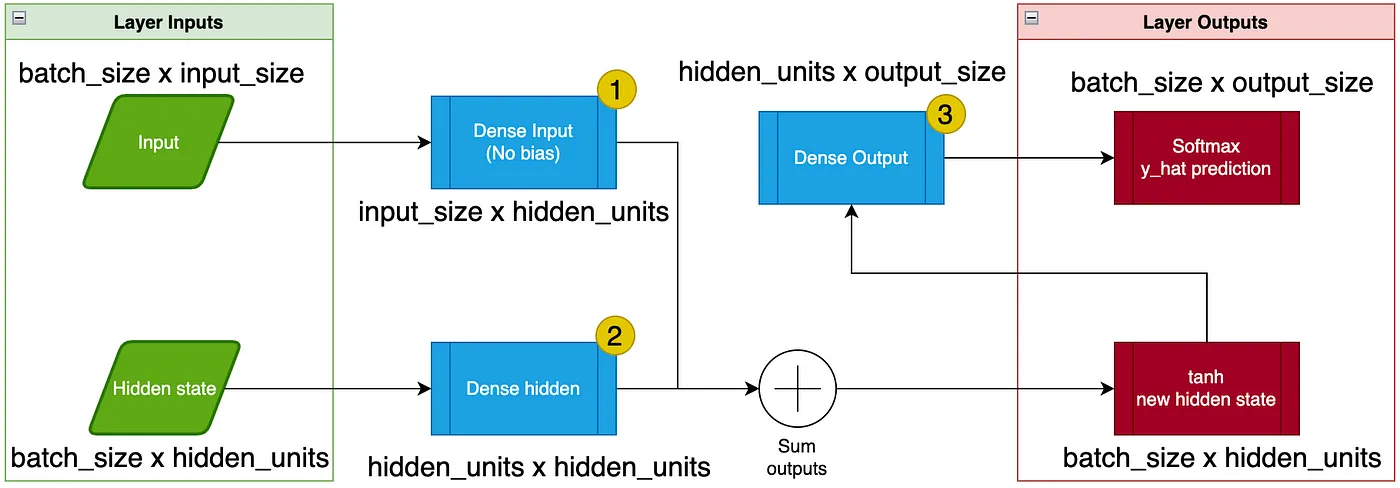

每个可训练矩阵的大小：
1. batch_size x hidden_units
2. hidden_units x hidden_units
3. batch_size x output size

In [ ]:
class TextDataset(Dataset):
    """
    将文本转化为向量表示
    ----------
    seq_length - int: 序列长度
    chars - list(str): 字符数组
    char_to_idx - dict: character to index 的字典
    idx_to_char - dict: index to character 的字典
    vocab_size - int: 字典大小
    data_size - int: 文本总长度
    """
    def __init__(self, text_data: str, seq_length: int = 25) -> None:
        """
        text_data: string 类型 输入的文本数据
        seq_length: 序列的长度，每个文本集中的字符数量
        """
        self.chars = sorted(list(set(text_data)))
        self.data_size, self.vocab_size = len(text_data), len(self.chars)
        # 创建基于index 或 character 的索引字典
        self.idx_to_char = {i:ch for i, ch in enumerate(self.chars)}
        self.char_to_idx = {ch:i for i, ch in enumerate(self.chars)}
        self.seq_length = seq_length
        self.X = self.string_to_vector(text_data)
    
    @property
    def X_string(self) -> str:
        """
        返回X的string表达
        """
        return self.vector_to_string(self.X)
        
    def __len__(self) -> int:
        return int(len(self.X) / self.seq_length -1)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        """
        X和Y有一样的形状，但是Y的取值向右移动一位
        """
        start_idx = index * self.seq_length
        end_idx = (index + 1) * self.seq_length

        X = torch.tensor(self.X[start_idx:end_idx]).float()
        y = torch.tensor(self.X[start_idx+1:end_idx+1]).float()
        return X, y
    
    def string_to_vector(self, name: str) -> list[int]:
        """
        将字符基于字典转化为1维向量
        如 string_to_vector('test')
        [20, 5, 19, 20]
        """
        vector = list()
        for s in name:
            vector.append(self.char_to_idx[s])
        return vector

    def vector_to_string(self, vector: list[int]) -> str:
        """
        将一个1维向量转换回字符数组
        如 >>> vector_to_string([20, 5, 19, 20])
        'test'
        """
        vector_string = ""
        for i in vector:
            vector_string += self.idx_to_char[i]
        return vector_string

In [ ]:
def generate_text(model: RNN, dataset: TextDataset, prediction_length: int = 100) -> str:
    """
    inference 函数
    使用dataset文本集预测指定长度的文本
    """
    model.eval() # 固定模型参数
    predicted = dataset.vector_to_string([random.randint(0, len(dataset.chars) -1)])
    hidden = model.init_zero_hidden() # 初始化隐藏层参数

    for i in range(prediction_length - 1):
        last_char = torch.Tensor([dataset.char_to_idx[predicted[-1]]])
        X, hidden = last_char.to(device), hidden.to(device)
        out, hidden = model(X, hidden)
        result = torch.multinomial(nn.functional.softmax(out, 1), 1).item() # 使用多项式分布，softmax进行预测得到最大概率index
        #result = out.argmax().item()
        predicted += dataset.idx_to_char[result] # 将index转化为文本

    return predicted

In [ ]:
def train(model: RNN, data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module) -> None:
    """
    model: RNN模型参数
    data: 可迭代的DataLoader
    epochs: 训练轮数
    optiimizer: 优化器函数
    loss_fn: 损失函数
    """
    train_losses = {}
    model.to(device)
    
    model.train()
    print("=> Starting training")
    for epoch in range(epochs):
        epoch_losses = list()
        for X, Y in data:
            # 如果batch的大小与模型设定的batch不匹配则跳过
            if X.shape[0] != model.batch_size:
                continue
            hidden = model.init_zero_hidden(batch_size=model.batch_size)
            # 将张量送入模型中
            X, Y, hidden = X.to(device), Y.to(device), hidden.to(device)
            # 清除梯度
            model.zero_grad()
            loss = 0
            for c in range(X.shape[1]):
                out, hidden = model(X[:, c].reshape(X.shape[0],1), hidden)
                l = loss_fn(out, Y[:, c].long())
                loss += l
            # 计算梯队
            loss.backward()
            # 调整学习率，避免出现梯度爆炸或消失
            nn.utils.clip_grad_norm_(model.parameters(), 3)
            optimizer.step()
        
            epoch_losses.append(loss.detach().item() / X.shape[1])
        train_losses[epoch] = torch.tensor(epoch_losses).mean()
        print(f'=> epoch: {epoch + 1}, loss: {train_losses[epoch]}')
				# 每一个epoch后都生成一次文本
        print(generate_text(model, data.dataset))

In [ ]:
data = open('your_file.txt', 'r').read() # 使用你的文本替换训练集
data = data.lower()

# 超参数
seq_length = 25
batch_size = 64
hidden_size = 256

text_dataset = TextDataset(data, seq_length=seq_length)
text_dataloader = DataLoader(text_dataset, batch_size)

# 构建模型
rnnModel = RNN(1, hidden_size, len(text_dataset.chars)) # 每一次输入一个字符文本
# 训练参数
epochs = 1000
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(rnnModel.parameters(), lr = 0.001)

train(rnnModel, text_dataloader, epochs, optimizer, loss)